# Machine Learning in the SDSS catalog: 
## Photometric Redshift Estimation and Quasar Classification

Modern wide field surveys are generating very large databases of automatically measured objects, whose error properties may not be well understood. Fast machine learning algorithms have been proved to be very useful in such a regime.

Let's investigate the SDSS photometric object catalog, and look for machine learning solutions to the following two problems:

1. Estimating the redshifts of quasars from their photometry (regression)

1. Selecting quasars from a background of stars and galaxies (classification)

## Data Aquisition

From the SDSS Sky Server we've downloaded two types of photometry (aperature and petrosian), corrected for extinction, for a number of sources with redshifts. Here's the SQL for an example query, that gets us 10000 example quasars:

<font color="blue">
 <pre>SELECT *,dered_u - mag_u AS diff_u, dered_g - mag_g AS diff_g, dered_r - mag_r AS diff_g, dered_i - mag_i AS diff_i, dered_z - mag_z AS diff_z from
(SELECT top 10000
objid, ra, dec, dered_u,dered_g,dered_r,dered_i,dered_z,psfmag_u-extinction_u AS mag_u,
psfmag_g-extinction_g AS mag_g, psfmag_r-extinction_r AS mag_r, psfmag_i-extinction_i AS mag_i,psfmag_z-extinction_z AS mag_z,z AS spec_z,dered_u - dered_g AS u_g_color, 
dered_g - dered_r AS g_r_color,dered_r - dered_i AS r_i_color,dered_i - dered_z AS i_z_color,class
FROM SpecPhoto 
WHERE 
 (class = 'QSO')
 ) as sp
 </pre>
</font>

We've got 1000 stars and 1000 galaxies as well, and saved them for convenience.

In [1]:
# For pretty plotting
# !pip install --upgrade seaborn

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
%pylab inline
import seaborn as sns
sns.set()
import copy
from __future__ import print_function

Populating the interactive namespace from numpy and matplotlib


## Photometric Redshift Estimation

* This is a regression problem, to be able to predict the redshift response variable given a number of photometric measurement "features".


* Let's read in our SDSS quasars, and munge them into machine learning inputs.

In [3]:
qsos = pd.read_csv("data/qso10000.csv",index_col=0,usecols=["objid","dered_r","spec_z","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z"])

# Clean out extreme colors and bad magnitudes:
qsos = qsos[(qsos["dered_r"] > -9999) & (qsos["g_r_color"] > -10) & (qsos["g_r_color"] < 10)]


# Response variables: redshift
qso_redshifts = qsos["spec_z"]

# Features or attributes: photometric measurements
qso_features = copy.copy(qsos)
del qso_features["spec_z"]
qso_features.head()

,dered_r,u_g_color,g_r_color,r_i_color,i_z_color,diff_u,diff_g1,diff_i,diff_z
objid,,,,,,,,,
1237648720142532813,19.25328,0.331583,0.058027,0.099751,0.020077,-0.073151,-0.074903,-0.094942,-0.079136
1237658425156829371,19.16626,0.047575,0.181847,0.234743,-0.128612,-0.007589,-0.017090,-0.010700,-0.020636
1237660413189095710,18.70672,0.214582,0.182318,0.121645,-0.028202,-0.007397,0.002148,0.006218,-0.012548
1237660412651962520,19.52941,0.136745,0.222052,-0.120590,0.125301,0.001118,-0.005716,-0.020527,0.022139
1237658493336944662,18.15901,0.052462,0.247498,0.387709,0.011444,-0.098282,-0.244150,-0.238779,-0.271137


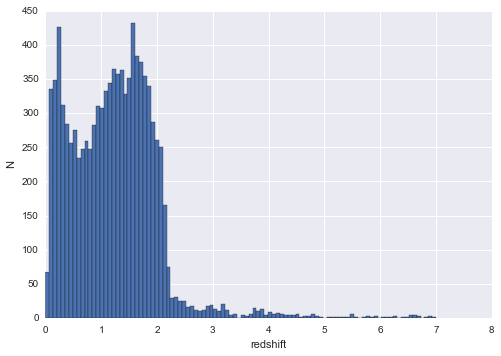

In [4]:
bins =  hist(qso_redshifts.values,bins=100) ; xlabel("redshift") ; ylabel("N")

Pretty clearly a big cut at around $z=2$.

Let's plot all the features, colored by the target redshift, to look for structure.

/Users/pjm/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


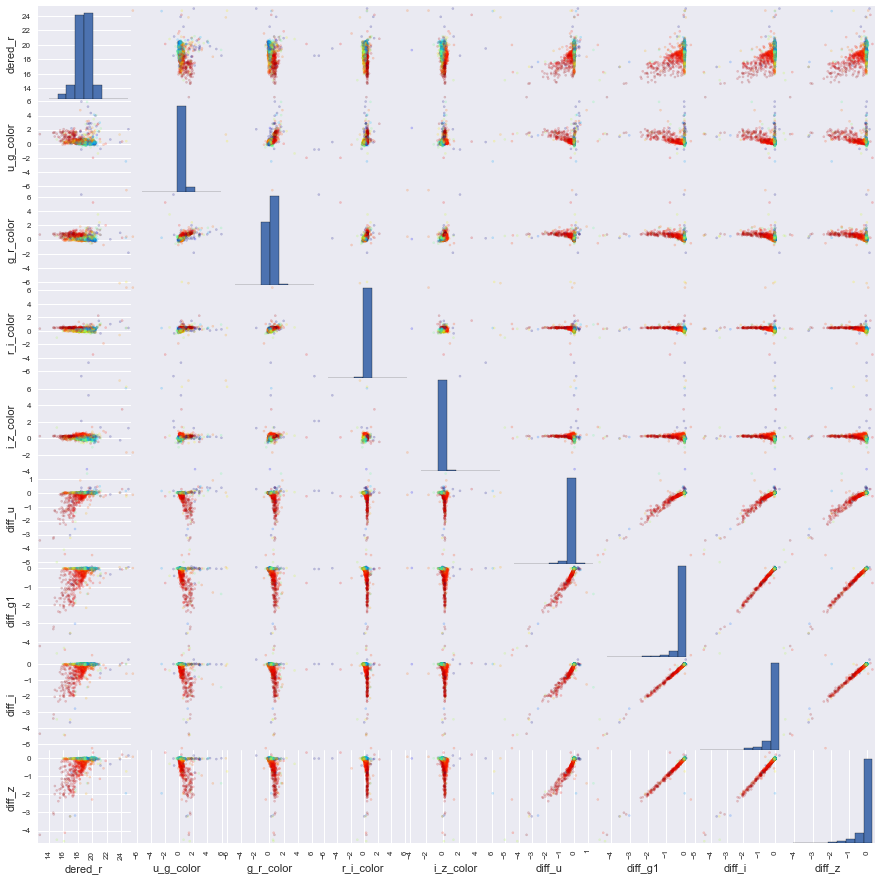

In [5]:
import matplotlib as mpl
import matplotlib.cm as cm

# Truncate the color at z=2.5 just to keep some contrast.
norm = mpl.colors.Normalize(vmin=min(qso_redshifts.values), vmax=2.5)
cmap = cm.jet_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot everything against everything else:
rez = pd.scatter_matrix(qso_features[0:2000],alpha=0.2,figsize=[15,15],color=m.to_rgba(qso_redshifts.values))

Now we have our machine learning inputs and outputs:

In [6]:
X = qso_features.values  # Data: 9-d feature space
y = qso_redshifts.values # Target: redshifts

In [7]:
print("Design matrix shape =", X.shape)
print("Response variable vector shape =", y.shape)

Design matrix shape = (9988, 9)
Response variable vector shape = (9988,)


In [8]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Linear Regression

Let's follow the same procedure as in the [`SciKit-Learn` tutorial](../../scikit-learn/Linear_Regression.ipynb) we just went through:

In [9]:
from sklearn import linear_model
linear = linear_model.LinearRegression()

# Fit the model, using all the attributes:
linear.fit(X_train, y_train)

# Do the prediction on the test data:
y_lr_pred = linear.predict(X_test)

# How well did we do?
from sklearn.metrics import mean_squared_error
mse_linear = np.sqrt(mean_squared_error(y_test,y_lr_pred))
r2_linear = linear.score(X_test, y_test)
print("Linear regression: MSE = ",mse_linear)
print("R2 score =",r2_linear)

Linear regression: MSE =  0.667932552349
R2 score = 0.234662212458


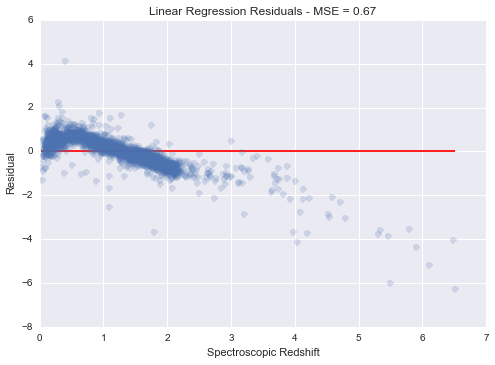

In [10]:
plot(y_test,y_lr_pred - y_test,'o',alpha=0.2)
title("Linear Regression Residuals - MSE = %.2f" % mse_linear)
xlabel("Spectroscopic Redshift")
ylabel("Residual")
hlines(0,min(y_test),max(y_test),color="red")

Just how bad is this? Here's the MSE from guessing the *average redshift of the training set* for all new objects:

In [11]:
print("Naive MSE", ((1./len(y_train))*(y_train - y_train.mean())**2).sum())
print("Linear regression: MSE = ",mse_linear)

Naive MSE 0.620004332607
Linear regression: MSE =  0.667932552349


In [12]:
mean_squared_error?

### *k*-Nearest Neighbor (KNN) Regression

Now let's try a different kind of model: a *non-parametric* one.

["Regression based on k-nearest neighbors. The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set."](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)


#### Question:

What underlying model is implied by the KNN algorithm? How many hidden parameters does it have?

In [13]:
from sklearn import neighbors
from sklearn import preprocessing

X_scaled = preprocessing.scale(X) # Many methods work better on scaled X.

KNN = neighbors.KNeighborsRegressor(5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

KNN.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [14]:
y_knn_pred = KNN.predict(X_test)
mse_knn = mean_squared_error(y_test,y_knn_pred)
r2_knn = KNN.score(X_test, y_test)
print("MSE (KNN) =", mse_knn)
print("R2 score (KNN) =",r2_knn)
print("cf.")
print("MSE (linear regression) = ",mse_linear)
print("R2 score (linear regression) =",r2_linear)

MSE (KNN) = 0.237330956504
R2 score (KNN) = 0.604993461373
cf.
MSE (linear regression) =  0.667932552349
R2 score (linear regression) = 0.234662212458


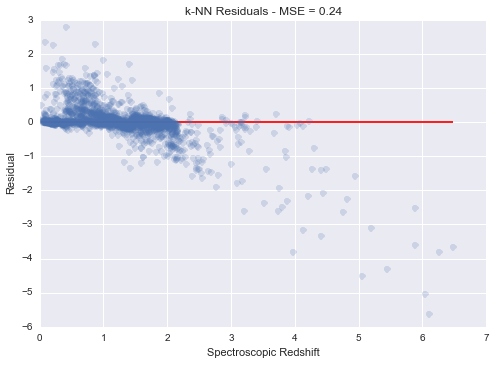

In [15]:
plot(y_test, y_knn_pred - y_test,'o',alpha=0.2)
title("k-NN Residuals - MSE = %.2f" % mse_knn)
xlabel("Spectroscopic Redshift")
ylabel("Residual")
hlines(0,min(y_test),max(y_test),color="red")

### Tuning the KNN Model

* Let's vary the control parameters of the KNN model, to see how good we can make our predictions.

* We can see our options in the model `repr`:

> KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_neighbors=5, p=2, weights='uniform')

* Let's first make a "validation curve" to investigate one parameter: the number of nearest neighbors averaged over.

In [16]:
# We'll vary the number of neighbors used:
param_name = "n_neighbors"
param_range = np.array([1,2,4,8,16,32,64])

# And we'll need a cv iterator:
from sklearn.cross_validation import ShuffleSplit
shuffle_split = ShuffleSplit(len(X), 10, test_size=0.4)

# Compute our cv scores for a range of the no. of neighbors:
from sklearn.learning_curve import validation_curve
training_scores, validation_scores = validation_curve(KNN, X_scaled, y,
                                                      param_name=param_name,
                                                      param_range=param_range, 
                                                      cv=shuffle_split, scoring='r2')

In [17]:
def plot_validation_curve(param_name,parameter_values, training_scores, validation_scores):
    training_scores_mean = np.mean(training_scores, axis=1)
    training_scores_std = np.std(training_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, training_scores_mean - training_scores_std,
                     training_scores_mean + training_scores_std, alpha=0.1, color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, training_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, training_scores_mean.max() + .1)
    plt.xlabel(param_name)
    plt.legend(loc="best")

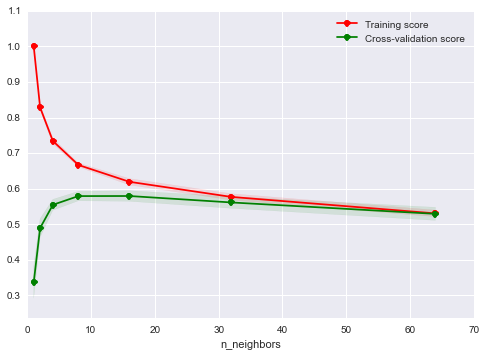

In [18]:
plot_validation_curve(param_name, param_range, training_scores, validation_scores)

#### Question:

Can you explain the shapes of these two curves? Talk to your neighbor for a few minutes, and be prepared to suggest reasons for a) the rise and fall of the cross validation score and b) the monotonic decrease in training score.

#### Model tuning with `GridSearchCV`

* Now, let's see if we can do better by varying some other KNN options as well - in a *grid search*.

In [19]:
param_grid = {'n_neighbors': np.array([1,2,4,8,16,32,64]),
                  'weights': ['uniform','distance'],
                       'p' : np.array([1,2])}

np.set_printoptions(suppress=True)
print(param_grid)

{'n_neighbors': array([ 1,  2,  4,  8, 16, 32, 64]), 'weights': ['uniform', 'distance'], 'p': array([1, 2])}


In [20]:
from sklearn.grid_search import GridSearchCV
KNN_tuned = GridSearchCV(KNN, param_grid, verbose=3)

A `GridSearchCV` object behaves just like a model, except it carries out a cross-validation while fitting:

<img src="../../scikit-learn/figures/grid_search_cross_validation.svg" width=100%>

In [21]:
KNN_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.357403 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.403915 -   0.2s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.131532 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.357403 -   0.2s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.403915 -   0.2s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.131532 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neig

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    4.0s



[CV] n_neighbors=4, weights=uniform, p=2 .............................
[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.520538 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.570498 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.495222 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.517041 -   0.1s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.595811 -   0.2s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.541184 -   0.2s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.586996 -   0.2s
[CV] 

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   15.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=64, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  4,  8, 16, 32, 64]), 'weights': ['uniform', 'distance'], 'p': array([1, 2])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=3)

In [22]:
y_knn_tuned_pred = KNN_tuned.predict(X_test)

mse_knn_tuned = mean_squared_error(y_test,y_knn_tuned_pred)
r2_knn_tuned = KNN_tuned.score(X_test, y_test)

print("MSE (tuned KNN) =", mse_knn_tuned)
print("R2 score (tuned KNN) =",r2_knn_tuned)
print("cf.")
print("MSE (KNN) = ",mse_knn)
print("R2 score (KNN) =",r2_knn)

MSE (tuned KNN) = 0.217389157953
R2 score (tuned KNN) = 0.63818399385
cf.
MSE (KNN) =  0.237330956504
R2 score (KNN) = 0.604993461373


Which are the best KNN control parameters we found?

In [23]:
KNN_tuned.best_params_

{'n_neighbors': 8, 'p': 1, 'weights': 'distance'}

This value of `n_neighbors` is consistent with the peak in cross-validation score in the validation curve plot.

#### Generalization Error

Notice that all the above tuning happened while training on a single split (`X_train` and `y_train`).


It's possible that that particular fold prefers a slightly different set of parameters than a different one - so to assess our generalization error, we need a further level of cross-validation.


We can do this by passing a `GridSearchCV` model to the cross validation score calculator. This will take a few moments, as the grid search is carried out for each CV fold...

In [24]:
from sklearn.cross_validation import cross_val_score

R2 = cross_val_score(KNN_tuned, X_scaled, y, cv=shuffle_split, scoring='r2')

Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.391208 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.261632 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.262528 -   0.2s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.391208 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.261632 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.262528 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neig

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    2.9s



[CV] n_neighbors=4, weights=uniform, p=2 .............................
[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.482361 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.561793 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.515164 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.480626 -   0.2s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.613466 -   0.2s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.561134 -   0.3s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.495502 -   0.2s
[CV] 

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s



[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.269447 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.365230 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.405130 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.269447 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.365230 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neighbors=1, weights=uniform, p=2, score=0.362118 -   0.0s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neighbors=1, weights=uniform, p=2, score=0.296218 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    9.0s finished



Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.330758 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.380891 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.340799 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.330758 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.380891 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.340799 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_nei

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    2.1s



[CV] n_neighbors=4, weights=uniform, p=2 .............................
[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.515186 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.574760 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.554720 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.519653 -   0.1s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.588353 -   0.1s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.566169 -   0.1s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.537230 -   0.1s
[CV] 

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s



[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.265282 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.341937 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.427457 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.265282 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.341937 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neighbors=1, weights=uniform, p=2, score=0.409941 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neighbors=1, weights=uniform, p=2, score=0.321168 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    8.0s finished



Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.355134 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.280507 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.304392 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.355134 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.280507 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.304392 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_nei

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    2.0s



[CV] n_neighbors=4, weights=uniform, p=2 .............................
[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.551416 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.576598 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.529979 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.541880 -   0.1s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.622653 -   0.1s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.551083 -   0.1s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.595790 -   0.1s
[CV] 

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s



[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.419776 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.325993 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.362979 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.419776 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.325993 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neighbors=1, weights=uniform, p=2, score=0.345180 -   0.0s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neighbors=1, weights=uniform, p=2, score=0.375002 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    8.6s finished



Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.287706 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.286047 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.462045 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.287706 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.286047 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.462045 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_nei

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    2.3s



[CV] n_neighbors=4, weights=uniform, p=2 .............................
[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.548515 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.578571 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.477596 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.555004 -   0.1s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.672138 -   0.1s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.531075 -   0.1s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.579289 -   0.1s
[CV] 

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s



[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.212755 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.161112 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.366840 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.212755 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.161112 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neighbors=1, weights=uniform, p=2, score=0.305392 -   0.0s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neighbors=1, weights=uniform, p=2, score=0.258912 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    8.0s finished



Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.379055 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.325685 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.448212 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.379055 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.325685 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.448212 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_nei

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    2.6s



[CV] n_neighbors=4, weights=uniform, p=2 .............................
[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.586740 -   0.0s
[CV] n_neighbors=4, weights=uniform, p=2 .............................
[CV] .... n_neighbors=4, weights=uniform, p=2, score=0.533712 -   0.0s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.564038 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.592380 -   0.1s
[CV] n_neighbors=4, weights=distance, p=2 ............................
[CV] ... n_neighbors=4, weights=distance, p=2, score=0.534632 -   0.1s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.607033 -   0.1s
[CV] n_neighbors=8, weights=uniform, p=1 .............................
[CV] .... n_neighbors=8, weights=uniform, p=1, score=0.636959 -   0.1s
[CV] 

[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s



[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.516508 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=1 .............................
[CV] .... n_neighbors=1, weights=uniform, p=1, score=0.394755 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.373428 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.516508 -   0.1s
[CV] n_neighbors=1, weights=distance, p=1 ............................
[CV] ... n_neighbors=1, weights=distance, p=1, score=0.394755 -   0.1s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neighbors=1, weights=uniform, p=2, score=0.418356 -   0.0s
[CV] n_neighbors=1, weights=uniform, p=2 .............................
[CV] .... n_neighbors=1, weights=uniform, p=2, score=0.433360 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    7.6s finished


In [25]:
meanR2,errR2 = np.mean(R2),np.std(R2)
print("Mean score:",meanR2,"+/-",errR2)

Mean score: 0.581439525878 +/- 0.0261081940412


### Notes

* Optimizing over control parameters (or hyper parameters) with grid search cross validation is a form of model selection.


* When presented with new data samples (photometry), and asked to predict the target response variables (photometric redshifts), we'll need a trained machine that has not been *over-fitted* to the training data.


* Minimizing and estimating the generalization error is a way to reduce the risk of getting this prediction wrong. 


* Let's finish off our photo-z machine learning algorithm.

In [26]:
KNNz = KNN_tuned.best_estimator_
KNNz.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=8, p=1, weights='distance')

In [27]:
j = 571
one_pretend_quasar = X_test[j,:]
zphoto = KNNz.predict(one_pretend_quasar)
zspec = y_test[j]
print("True redshift cf. KNN photo-z:",zspec,zphoto)

True redshift cf. KNN photo-z: 1.626005 [ 1.61894793]


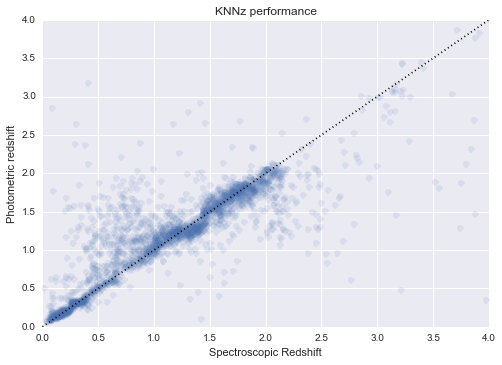

In [28]:
zspec = y_test
zphoto = KNNz.predict(X_test)

plot(zspec, zphoto,'o',alpha=0.1)
title("KNNz performance")
xlabel("Spectroscopic Redshift")
ylabel("Photometric redshift")
lims = [0.0,4.0]
xlim(lims)
ylim(lims)
plot(lims, lims, ':k')

## Quasar Classification with Random Forests


* Let's switch gears and do a 3-class classification problem: star, galaxy, or QSO.


* A very good general-purpose classification (and regression!) algorithm is Random Forest. See [this blog post](http://blog.yhathq.com/posts/random-forests-in-python.html) for a nice high level introduction.


* ["A random forest is a meta estimator that fits a number of *decision tree classifiers* on various sub-samples of the dataset, and uses averaging to improve the predictive accuracy and control over-fitting.](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)


* Let's read in equal numbers of all three types of data, clean them up, and set $y$ equal to the classification label.

In [29]:
all_sources = pd.read_csv("data/qso10000.csv",index_col=0,usecols=["objid","dered_r","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z","class"])[:1000]

all_sources = all_sources.append(pd.read_csv("data/star1000.csv",index_col=0,usecols=["objid","dered_r","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z","class"]))

all_sources = all_sources.append(pd.read_csv("data/galaxy1000.csv",index_col=0,usecols=["objid","dered_r","u_g_color",\
                                                "g_r_color","r_i_color","i_z_color","diff_u",\
                                                "diff_g1","diff_i","diff_z","class"]))

all_sources = all_sources[(all_sources["dered_r"] > -9999) & (all_sources["g_r_color"] > -10) & (all_sources["g_r_color"] < 10)]

all_labels = all_sources["class"]

all_features = copy.copy(all_sources)
del all_features["class"]

X = copy.copy(all_features.values)
y = copy.copy(all_labels.values)

In [30]:
all_labels.tail()

objid
1237657775542632759    GALAXY
1237657775542698090    GALAXY
1237657775542698177    GALAXY
1237657630586634463    GALAXY
1237657630049698007    GALAXY
Name: class, dtype: object

In [31]:
print("Feature vector shape =", X.shape)
print("Class label vector shape =", y.shape)

Feature vector shape = (3000, 9)
Class label vector shape = (3000,)


What structure can we see in the data? Let's plot all the features as before.

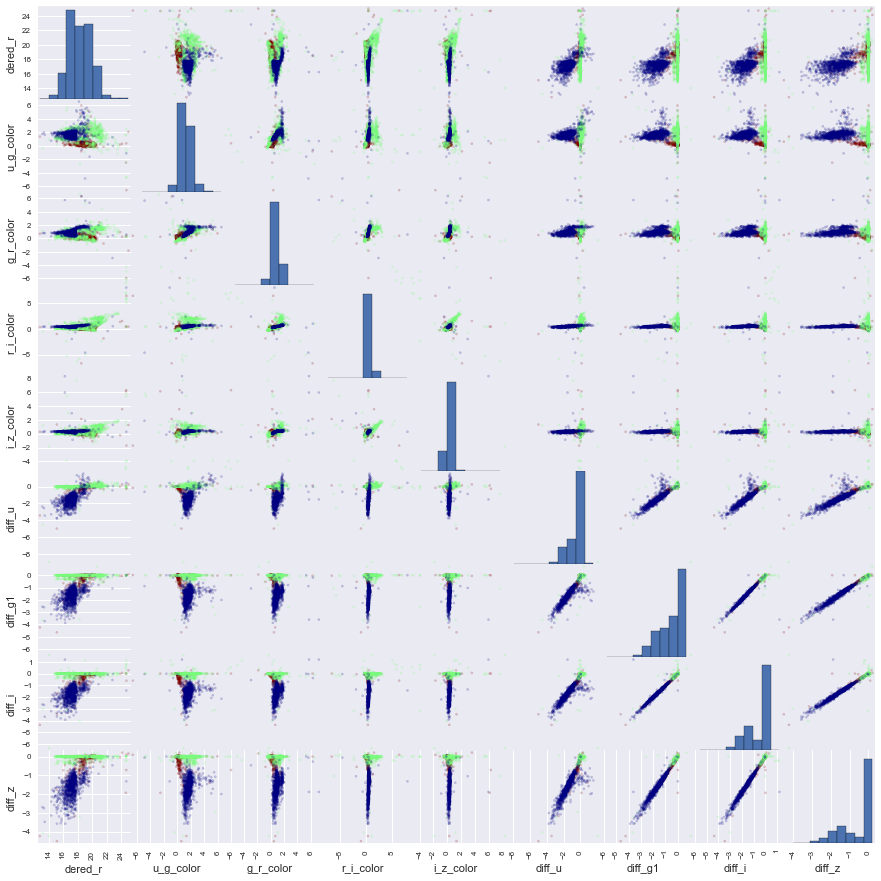

In [32]:
yy = all_labels.values.copy()
yy[yy=="QSO"] = 0.0    # Red
yy[yy=="STAR"] = 0.5   # Green
yy[yy=="GALAXY"] = 1.0 # Blue

norm = mpl.colors.Normalize(vmin=min(yy), vmax=max(yy))
cmap = cm.jet_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)
rez = pd.scatter_matrix(all_features,alpha=0.2,figsize=[15,15],color=m.to_rgba(yy))

OK - looks like there is information there to be used! 
Let's turn on the machine learning.

### Random Forest Classification

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,oob_score=True)
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

What are the important features in the data?

In [36]:
sorted(zip(all_sources.columns.values,rf.feature_importances_),key=lambda q: q[1],reverse=True)

[('u_g_color', 0.25397713059808968),
 ('diff_g1', 0.18328375353501078),
 ('diff_i', 0.13841198702897281),
 ('diff_z', 0.11583445541491962),
 ('g_r_color', 0.10521681242149176),
 ('diff_u', 0.067486541953700213),
 ('dered_r', 0.049900786896641583),
 ('r_i_color', 0.049365799894167832),
 ('i_z_color', 0.036522732257005794)]

In [38]:
rf.oob_score_

0.95433333333333337

This is the "Out of Bag" accuracy (of predicted y compared to truth), made available by ensemble classifiers. (Each decision tree in the ensemble is only working on a subset of the data, so it can track its accuracy with the data not in its own bag.) 

The accuracy of a classifier is the fraction of predictions made that are correct. This one looks like its doing well - but this is the accuracy on the training set.

### Classifier improvement with GridSearchCV

In [39]:
# Parameter values to try:
parameters = {'n_estimators':(50,100,200),"max_features": ["auto",3],
              'criterion':["gini","entropy"],"min_samples_leaf": [1,2]}

# Initial training/test split:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [40]:
# Do a grid search to find the highest 3-fold CV score:
rf_tuned = GridSearchCV(rf, parameters, cv=3, verbose=1)
RFselector = rf_tuned.fit(X_train, y_train)

# Print the best score and estimator:
print(RFselector.best_score_)
print(RFselector.best_estimator_)

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:   17.9s


Fitting 3 folds for each of 24 candidates, totalling 72 fits
0.953333333333
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   29.1s finished


#### Question:

Would you be satisfied with a 95% successful classification fraction? Read the Random Forest `SciKit-Learn` docs to find some alternative scores, and think about when you might want to choose one of these instead. (Hint: imagine using a classifier to select a sample of *targets*.)

One way of visualizing classification accuracy is via a *confusion matrix*:

In [41]:
y_pred = RFselector.predict(X_test)

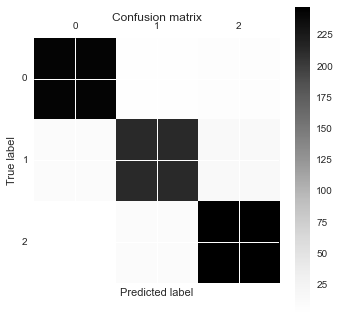

In [42]:
# Compute confusion matrix:

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Each output label comes with a *classification probability*, computed from the results of the whole forest. To select a sample of classified objects, one can choose a selection threshold in this class probability, and only keep objects with higher probability than this threshold.


The availability of a class probability leads to an important diagnostic: the "Receiver Operating Characteristic" or ["ROC" curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). This shows the *true positive rate* (TPR) plotted against the *false positive rate* (FPR) of a classifier, as the selection threshold is varied.


Typically, classifiers have control parameters that affect both the TPR and FPR (often improving one at the expense of the other), so the ROC curve is a good tool for investigating these parameters. 


Likewise, ROC curves provide a very good way to compare different classifiers.

### Exercise:

Use `SciKit-Learn` utilities to plot an ROC curve for the RFselector.

**[Back to the lesson plan](../../lessons/9.MachineLearning.ipynb)**